In [98]:
import numpy as np
from astropy.io import ascii
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import emcee
import corner
from chainconsumer import ChainConsumer
%matplotlib inline

In [99]:
# Data from GW170817

gw170817 = ascii.read('gw170817_afterglow_data_full.txt')
VLA_gw170817 = gw170817[(gw170817['Telescope'] == 'VLA') & (gw170817['Freq'] == 3.00e9)]
CH_gw170817 = gw170817[(gw170817['Telescope'] == 'Chandra')]

def safe_float(value):
    try:
        return float(value)
    except ValueError:
        return None
    
VLA_gw170817 = VLA_gw170817[[safe_float(x) is not None for x in VLA_gw170817['FluxD']]]

FluxD_VLA = np.array(VLA_gw170817['FluxD'].astype(float))
Time_VLA = np.array(VLA_gw170817['T'].astype(float))
Freq_VLA = np.array(VLA_gw170817['Freq'].astype(float))
FluxDErr_VLA = np.array(VLA_gw170817['FluxDErr'].astype(float))


CH_gw170817 = CH_gw170817[[safe_float(x) is not None for x in CH_gw170817['FluxD']]]

FluxD_CH = np.array(CH_gw170817['FluxD']).astype(float)
Time_CH = np.array(CH_gw170817['T']).astype(float)
Freq_CH = np.array(CH_gw170817['Freq']).astype(float)
FluxDErr_CH = np.array(CH_gw170817['FluxDErr']).astype(float)


# Scaling
scaling_factor = (max(FluxD_VLA)-min(FluxD_VLA))/(max(FluxD_CH)-min(FluxD_CH))
FluxD_CH = FluxD_CH*scaling_factor
FluxDErr_CH = FluxDErr_CH*scaling_factor

FluxD = np.concatenate((FluxD_VLA, FluxD_CH))
Time = np.concatenate((Time_VLA, Time_CH))
Freq = np.concatenate((Freq_VLA, Freq_CH))
FluxDErr = np.concatenate((FluxDErr_VLA, FluxDErr_CH))


sorted_indices = np.argsort(Time)
Time = Time[sorted_indices]
Freq = Freq[sorted_indices]
FluxD = FluxD[sorted_indices]
FluxDErr = FluxDErr[sorted_indices]



In [100]:
# Functions for MCMC

def smoothBrokenPowerLaw(params,t,v):
    """
    v : observing frequency
    b : spectral index
    s : smoothness parameter
    Fp : peak flux
    tp : peak time
    a1 : power-law rise
    a2 : power-law decay
    """
    s,Fp,tp,a1,a2,b = params
    return (2**(1/10**s))*((v/3e9)**b)*Fp*( (t/tp)**(-10**s*a1) + (t/tp)**(-10**s*a2) )**(-1/10**s)

def MCMC(setFlux,setTime,setErr,setFreq) :

    def lnlike(params,x, y, yerr):
        return -0.5 * np.sum(((y - smoothBrokenPowerLaw(params,x,setFreq))/yerr) ** 2)

    def lnprior(params):
        s,Fp,tp,a1,a2,b = params
        if 0<s<1.5 and 90<Fp<120 and 100<tp<200 and 0<a1<1 and -2<a2<-1 and -1<b<0:
            return 0.0
        return -np.inf

    def lnprob(params, x, y, yerr):
        lp = lnprior(params)
        if not np.isfinite(lp):
            return -np.inf
        return lp + lnlike(params, x, y, yerr)

    Data = (setTime, setFlux ,setErr)
    nwalkers = 248
    niter = 1000
    initial = np.array([0.56,100,155,0.86,-1.92,-0.58]) #s,Fp,tp,a1,a2,b
    ndim = len(initial)
    p0 = [np.array(initial) + 1e-7 * np.random.randn(ndim) for i in range(nwalkers)]


    def main(p0,nwalkers,niter,ndim,lnprob,data):
        sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data)

        print("Running burn-in...")
        p0, _, _ = sampler.run_mcmc(p0, 100)
        sampler.reset()

        print("Running production...")
        pos, prob, state = sampler.run_mcmc(p0, niter)

        return sampler, pos, prob, state

    sampler, pos, prob, state = main(p0,nwalkers,niter,ndim,lnprob,Data)

    return sampler, pos, prob, state

In [101]:
samplerCH, posCH, probCH, stateCH = MCMC(FluxD,Time,FluxDErr,Freq)
samplesCH = samplerCH.flatchain

Running burn-in...
Running production...


In [102]:
theta_max  = samplesCH[np.argmax(samplerCH.flatlnprobability)]
best_fit_model = smoothBrokenPowerLaw(theta_max,Time,Freq)
print(theta_max)

[ 8.01717579e-01  1.06469486e+02  1.51117217e+02  8.49432407e-01
 -1.78548095e+00 -7.35486892e-05]


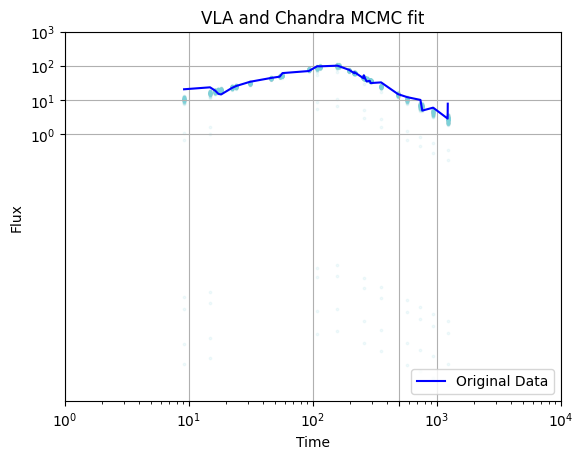

In [103]:


# Plotting Chandra data fit
plt.plot(Time,FluxD, color= 'b',label='Original Data')
for params in samplesCH[np.random.randint(len(samplesCH), size=100)]:
    plt.scatter(Time, smoothBrokenPowerLaw(params,Time,Freq), color="#7cd1d9",s=3, alpha=0.1)

yticks = [1, 10, 100, 1000]
plt.yscale('log') 
plt.yticks(yticks)


xticks = [1,10,100,500,1000,10000]
plt.xscale('log')
plt.xticks(xticks)

plt.minorticks_on()
plt.xlabel('Time')
plt.ylabel('Flux')
plt.grid()
plt.legend(loc='lower right')
plt.title('VLA and Chandra MCMC fit')
plt.show()

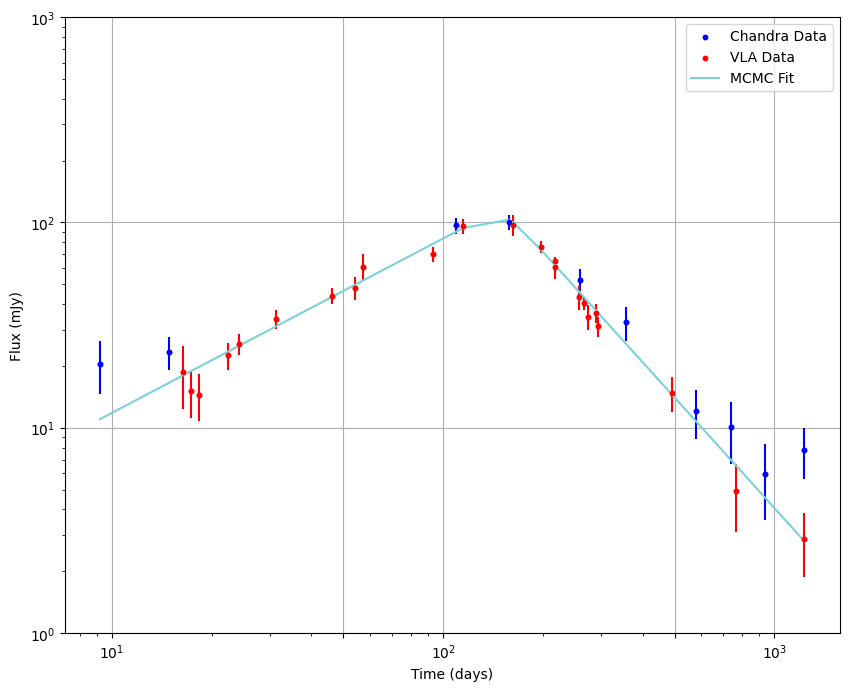

Chandra:  [ 8.01717579e-01  1.06469486e+02  1.51117217e+02  8.49432407e-01
 -1.78548095e+00 -7.35486892e-05]
VLA:  [ 8.01717579e-01  1.06469486e+02  1.51117217e+02  8.49432407e-01
 -1.78548095e+00 -7.35486892e-05]


In [111]:

theta_max  = samplesCH[np.argmax(samplerCH.flatlnprobability)]
best_fit_model = smoothBrokenPowerLaw(theta_max,Time,Freq)


fig = plt.figure(figsize=(10, 8))


plt.scatter(Time_CH,FluxD_CH,label='Chandra Data',color='b',s=10)
plt.errorbar(Time_CH,FluxD_CH,yerr=FluxDErr_CH,fmt='.',color='b')

plt.scatter(Time_VLA,FluxD_VLA,label='VLA Data',color='r',s=10)
plt.errorbar(Time_VLA,FluxD_VLA,yerr=FluxDErr_VLA,fmt='.',color='r')

plt.plot(Time,best_fit_model,label='MCMC Fit',color='#7cd1d9')



yticks = [1, 10, 100, 1000]
plt.yscale('log') 
plt.yticks(yticks)


xticks = [10,50,100,500,1000]
plt.xscale('log')
plt.xticks(xticks)

plt.xlabel('Time (days)')
plt.ylabel('Flux (mJy)')

plt.legend()
plt.grid()
    
plt.show()
print ('Chandra: ',theta_max)
print ('VLA: ',theta_max)

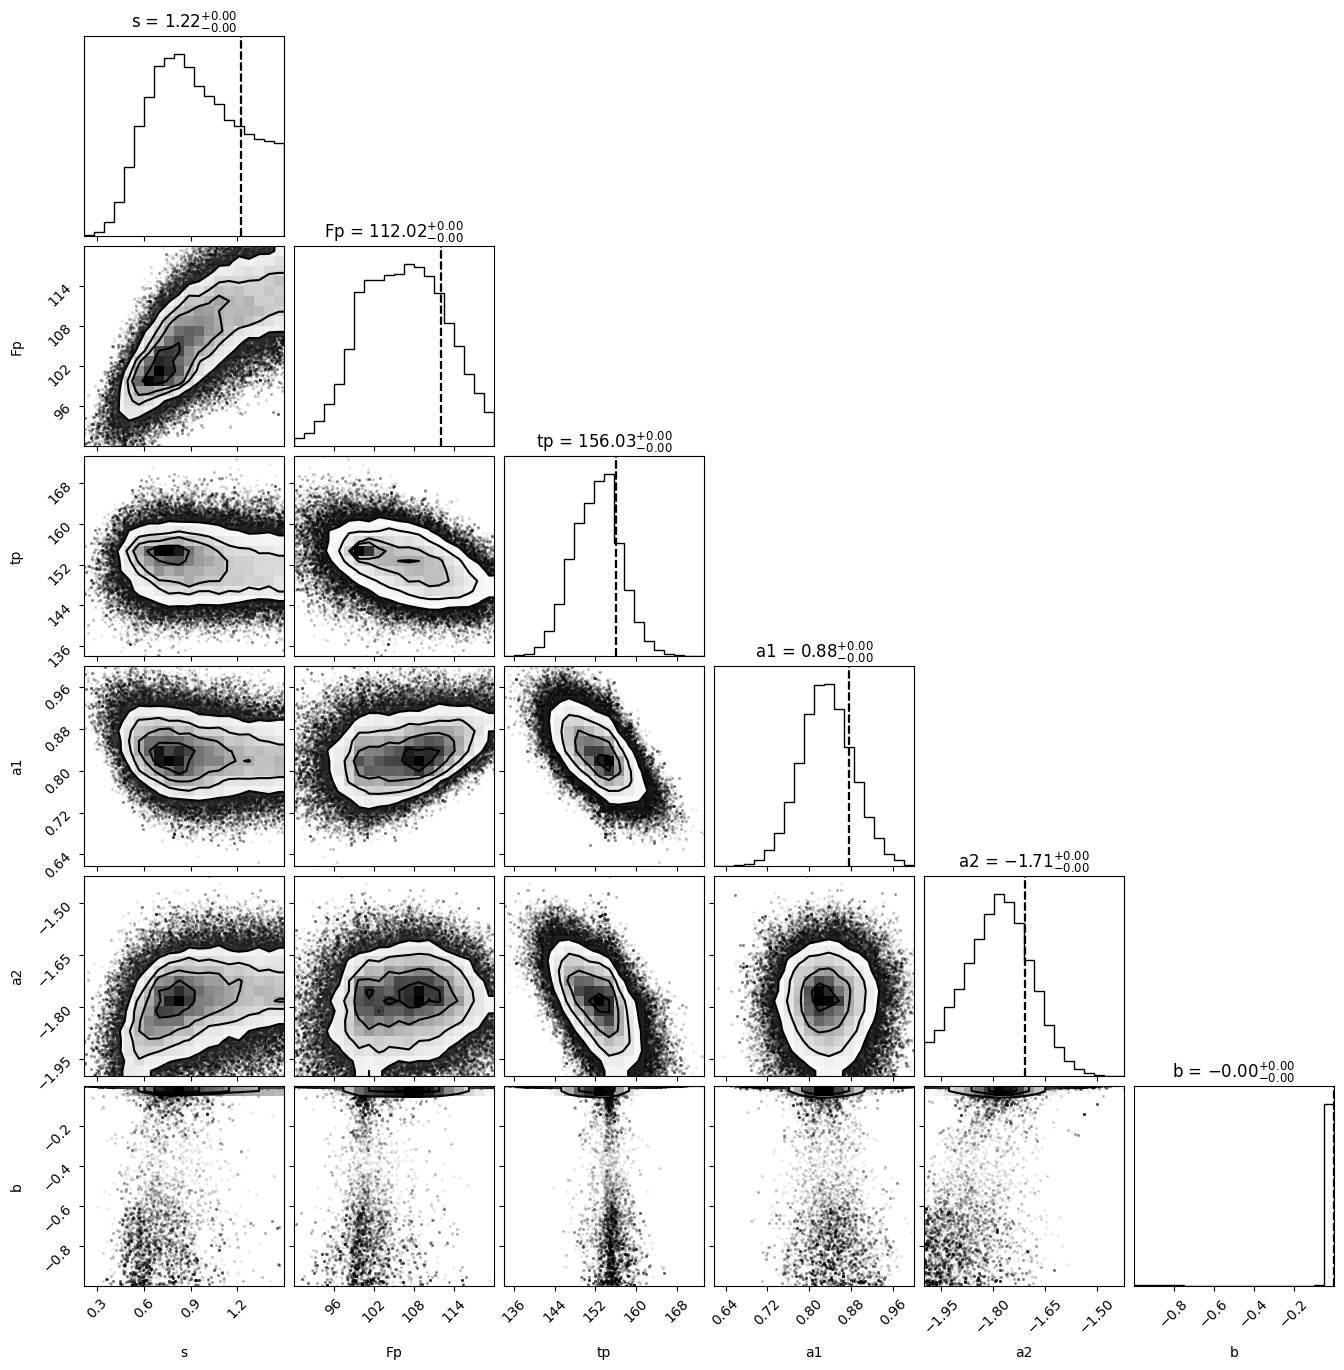

In [105]:
labels = ['s','Fp','tp','a1','a2','b']
fig = corner.corner(samplesCH,show_titles=True,labels=labels,plot_datapoints=True,quantiles=[0.8,0.8,0.8])

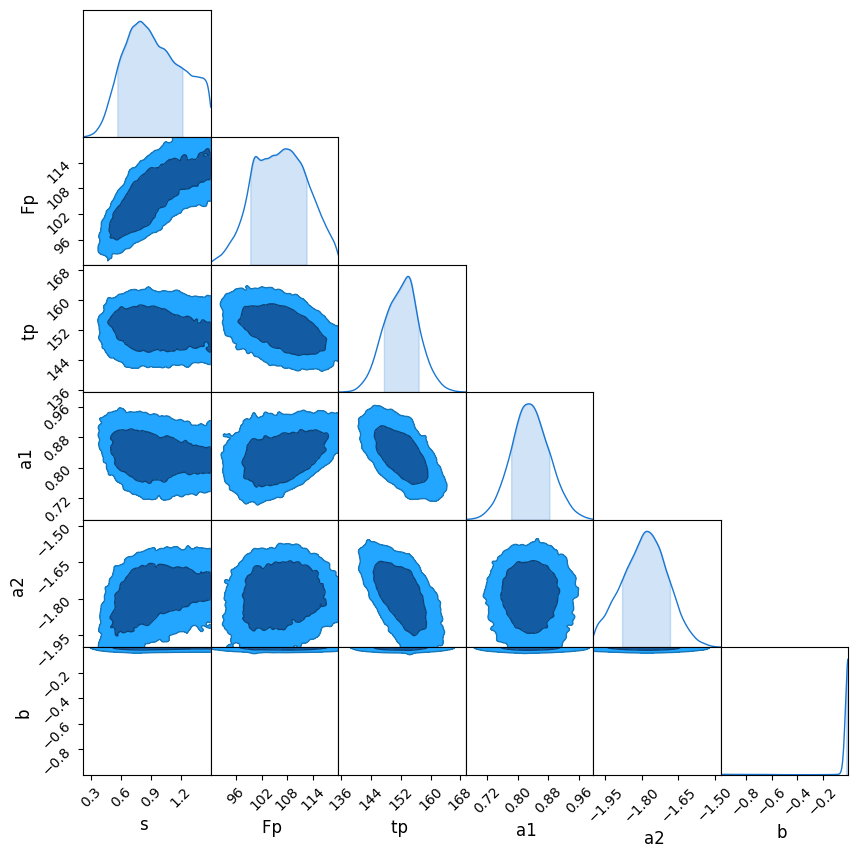

In [106]:
c = ChainConsumer()
c.add_chain(samplesCH, parameters=labels)
fig = c.plotter.plot(truth=[0.0, 4.0])